In [1]:
import json
import numpy as np
from functools import partial
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
from helper import load_mice_data, average_time_data, average_nonzero_duration, average_freq, frames_per_minute, frames_per_day

In [3]:
frame_within, frame_within_tail_behind, frame_within_tail_front, bout_start, bout_end, bout_duration, idx_order = load_mice_data(group="main")

In [4]:
near, near_behind, near_front = average_time_data(frame_within, frame_within_tail_behind, frame_within_tail_front, frames_per_minute, frames_per_minute, 1)
bout_duration_avg = average_nonzero_duration(frame_within, bout_duration, frames_per_minute, frames_per_minute, 1)
bout_freq = average_freq(frame_within, bout_start, frames_per_minute, frames_per_minute, 1, dataset="main")

/opt/anaconda3/envs/py39/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py39/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Box Fit

In [6]:
def fit_offsetbox_model_normalized(N, X, Y):
    X = X.astype(float)
    
    def normalize(v):
        mu = np.mean(v)
        sig = np.std(v)
        return (v-mu)/sig, mu, sig
    
    def inv_normalize(v, mu, sig):
        return v*sig + mu
    
    X_norm, mux, sigx = normalize(X)
    Y_norm, muy, sigy = normalize(Y)
    
    def piecewise_box(x, e, f, g, h):
        return np.piecewise(x, [x < e, (e <= x) & (x <= g), g < x], [lambda x:(0.0-muy)/sigy, lambda x:h, lambda x:f])

    def loss_fn(v):
        e, f, g, h = v
        return np.sum(np.abs(piecewise_box(X_norm, e, f, g, h)-Y_norm))

    theta_init = [np.min(X_norm), np.min(Y_norm), np.min(X_norm)+np.std(X_norm), np.max(Y_norm)]  # e, f, g, h
    result = optimize.basinhopping(loss_fn, theta_init, niter=N, T=3.0, stepsize=0.2)
    
    e, f, g, h = result.x
    e, f, g, h = [inv_normalize(e, mux, sigx), 
                      inv_normalize(f, muy, sigy), 
                      inv_normalize(g, mux, sigx),
                      inv_normalize(h, muy, sigy)]
    print("e:{:.1f} f:{:.3f} g:{:.1f} h:{:.3f}".format(e, f, g, h))
    
    return inv_normalize(piecewise_box(X_norm, *result.x), muy, sigy), [e, f, g, h]

In [7]:
def plot_ref_lines(ax, offset):
    ax.axvline(x=50-offset, color='k', linewidth=0.75);
    ax.axvline(x=125-offset, color='k', linewidth=0.75);
    ax.axvline(x=75-offset, color='k', linewidth=0.4);
    ax.axvline(x=100-offset, color='k', linewidth=0.4);

In [8]:
def plot_all(data, model_fn, offset=0, animals=None):
    near, near_front, near_behind = data
    
    net_params = {}
    behind_params = {}
    front_params = {}
    
    iter_list = idx_order if animals is None else animals
    
    for i in iter_list:
        print("Animal {:02d}".format(i))
        fig, (axt, axb) = plt.subplots(2, 2, figsize=(15,10))
        ax1, ax2 = axt
        ax3, ax4 = axb

        x = np.arange(50-offset, len(near_behind[i]))
        y = near_behind[i, 50-offset:]
        y_model, params = model_fn(x, y)
        behind_params[i]= params
        ax1.plot(x, y_model, color='orange')
        ax1.plot(near_behind[i], color='r')
        ax1.set_ylim(bottom=0)

        x = np.arange(50-offset, len(near_front[i]))
        y = near_front[i, 50-offset:]
        y_model, params = model_fn(x, y)
        front_params[i] = params        
        ax3.plot(x, y_model, color='orange')
        ax3.plot(near_front[i], color='g')
        ax3.set_ylim(bottom=0)
        
        ax2.plot(bout_freq[i], color='b')
        ax2.set_ylim(bottom=0)

        ax4.plot(bout_duration_avg[i], color='purple')
        ax4.set_ylim(bottom=0)
        
        plot_ref_lines(ax1, offset)
        plot_ref_lines(ax2, offset)
        plot_ref_lines(ax3, offset)
        plot_ref_lines(ax4, offset)
        plt.show();

    return net_params, behind_params, front_params

Animal 18
e:23.5 f:0.017 g:53.4 h:0.076
e:50.0 f:nan g:78.9 h:nan


/var/folders/w4/0mcdz01j0qdchr3sjwgq_xx80007vp/T/ipykernel_8518/1685228407.py:7: RuntimeWarning: invalid value encountered in divide
  return (v-mu)/sig, mu, sig
/var/folders/w4/0mcdz01j0qdchr3sjwgq_xx80007vp/T/ipykernel_8518/1685228407.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return np.piecewise(x, [x < e, (e <= x) & (x <= g), g < x], [lambda x:(0.0-muy)/sigy, lambda x:h, lambda x:f])


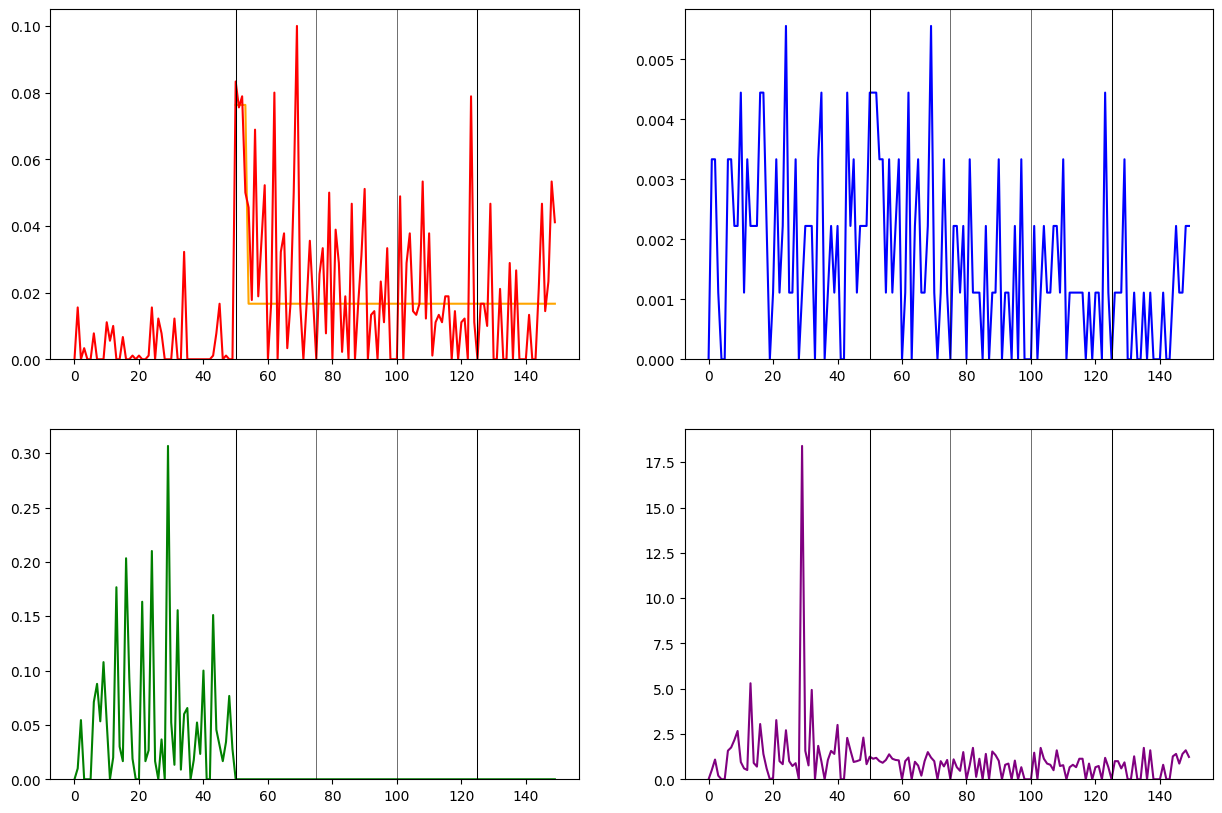

Animal 13
e:47.6 f:0.014 g:59.9 h:0.046
e:50.0 f:nan g:78.9 h:nan


/var/folders/w4/0mcdz01j0qdchr3sjwgq_xx80007vp/T/ipykernel_8518/1685228407.py:7: RuntimeWarning: invalid value encountered in divide
  return (v-mu)/sig, mu, sig
/var/folders/w4/0mcdz01j0qdchr3sjwgq_xx80007vp/T/ipykernel_8518/1685228407.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return np.piecewise(x, [x < e, (e <= x) & (x <= g), g < x], [lambda x:(0.0-muy)/sigy, lambda x:h, lambda x:f])


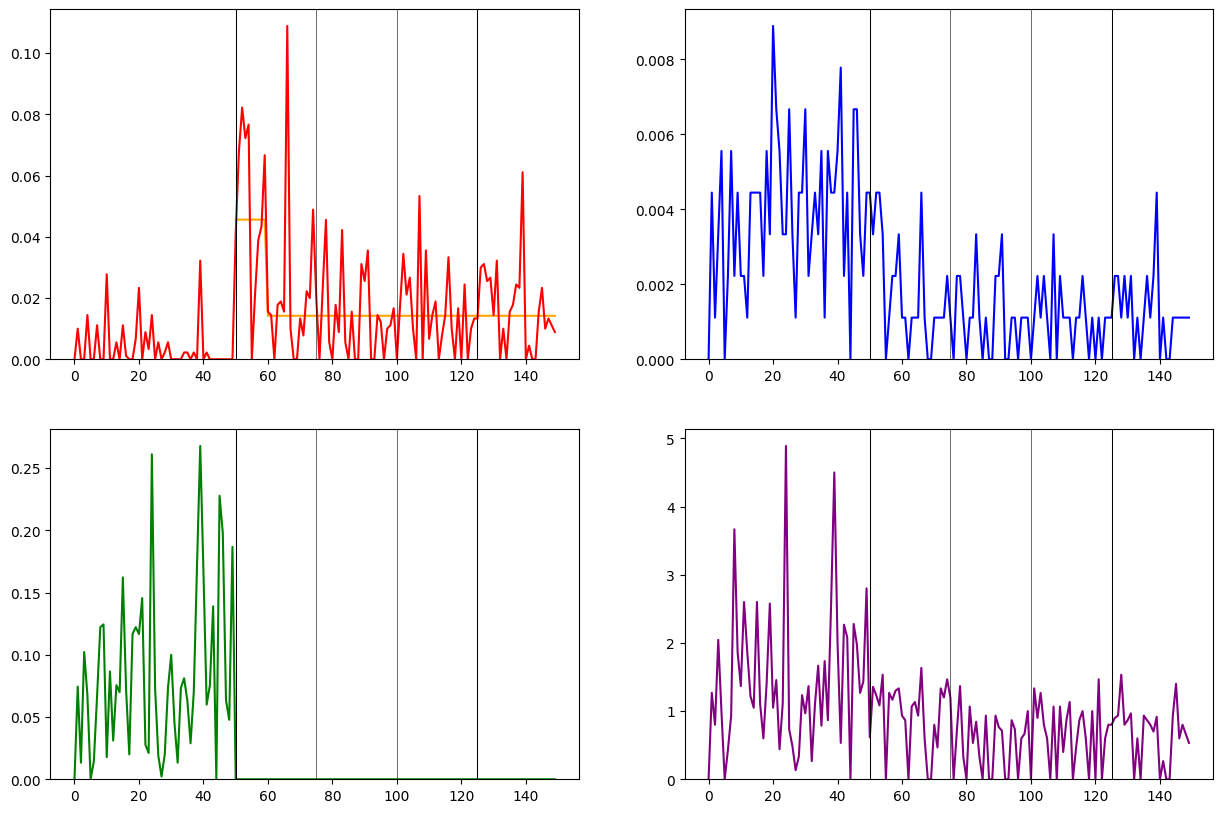

Animal 08
e:41.6 f:0.021 g:93.0 h:0.032
e:86.4 f:-0.000 g:80.3 h:0.000


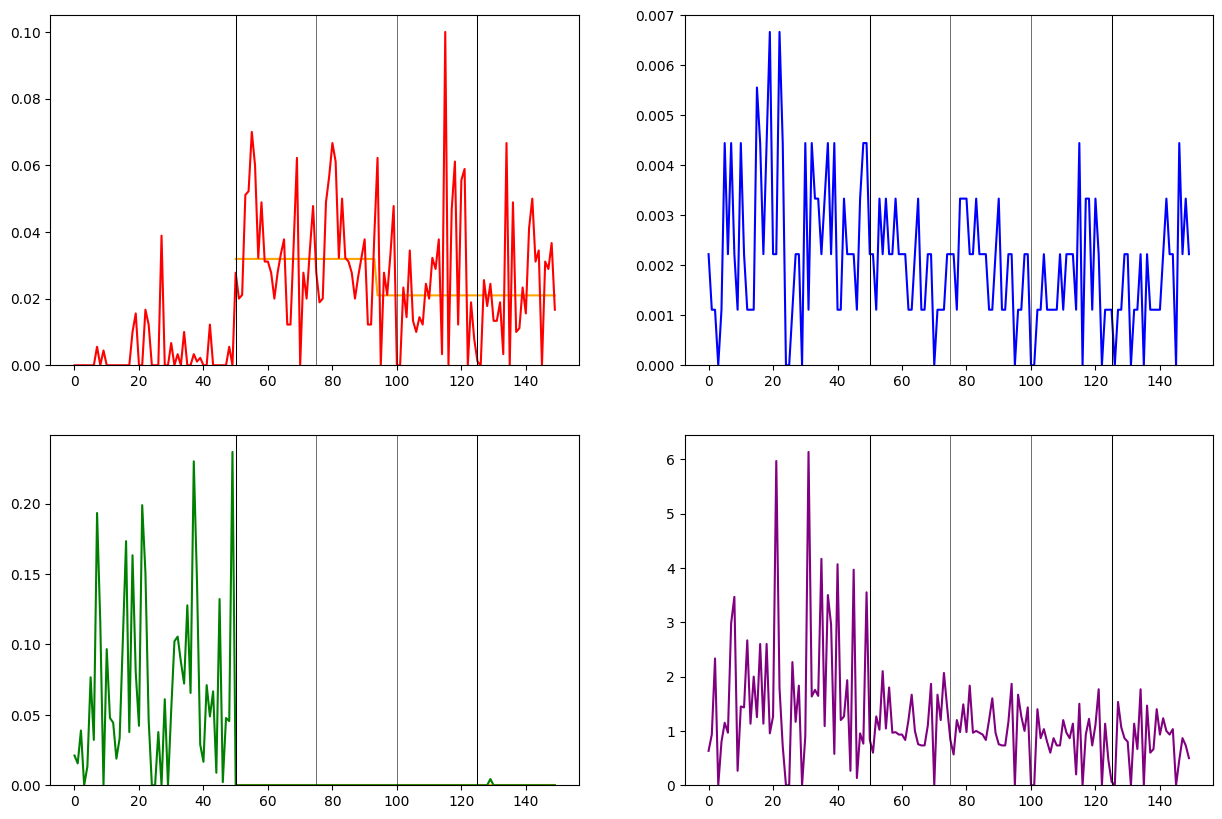

Animal 25
e:40.3 f:0.018 g:73.3 h:0.026
e:51.0 f:-0.000 g:83.1 h:-0.000


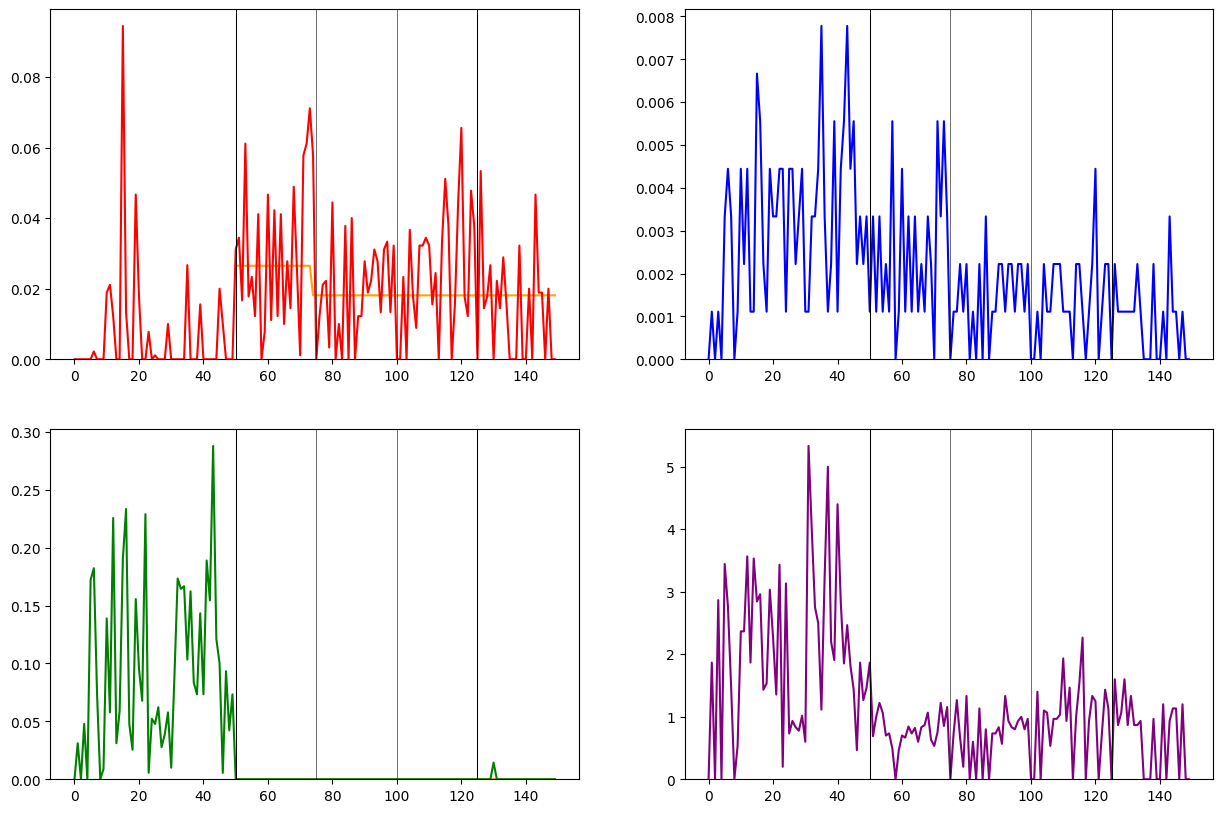

Animal 21
e:43.3 f:0.013 g:72.0 h:0.080
e:50.0 f:-0.000 g:78.9 h:0.004


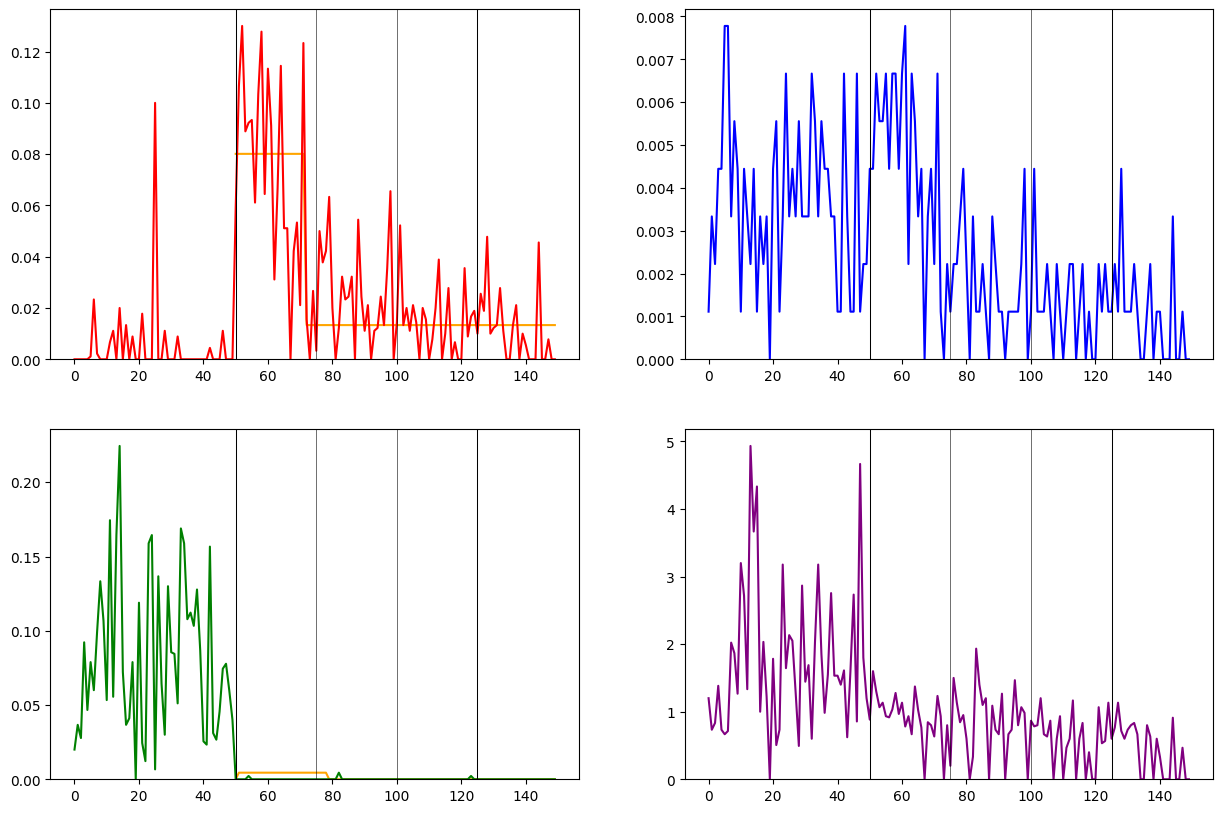

Animal 09
e:36.6 f:0.015 g:81.5 h:0.043
e:71.4 f:-0.000 g:75.3 h:-0.000


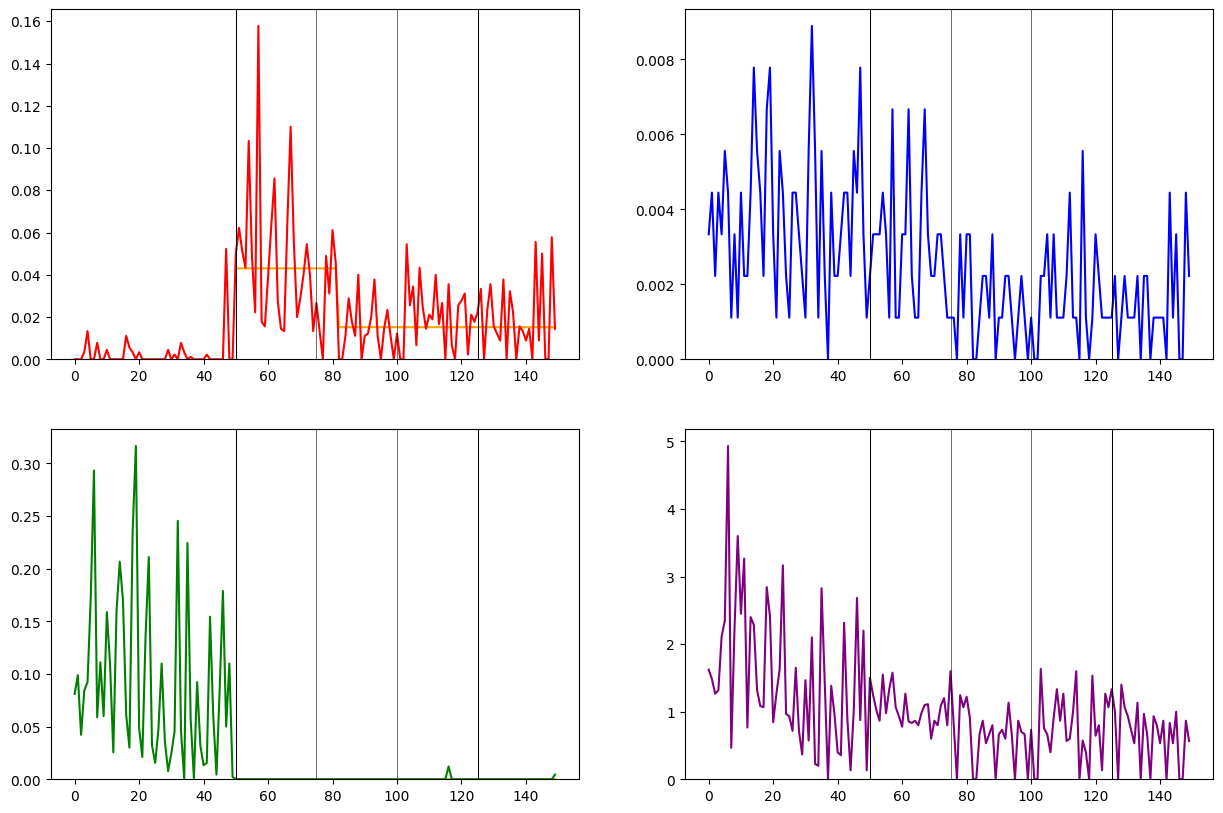

Animal 04
e:42.0 f:0.011 g:72.4 h:0.054
e:4.3 f:-0.000 g:71.4 h:-0.000


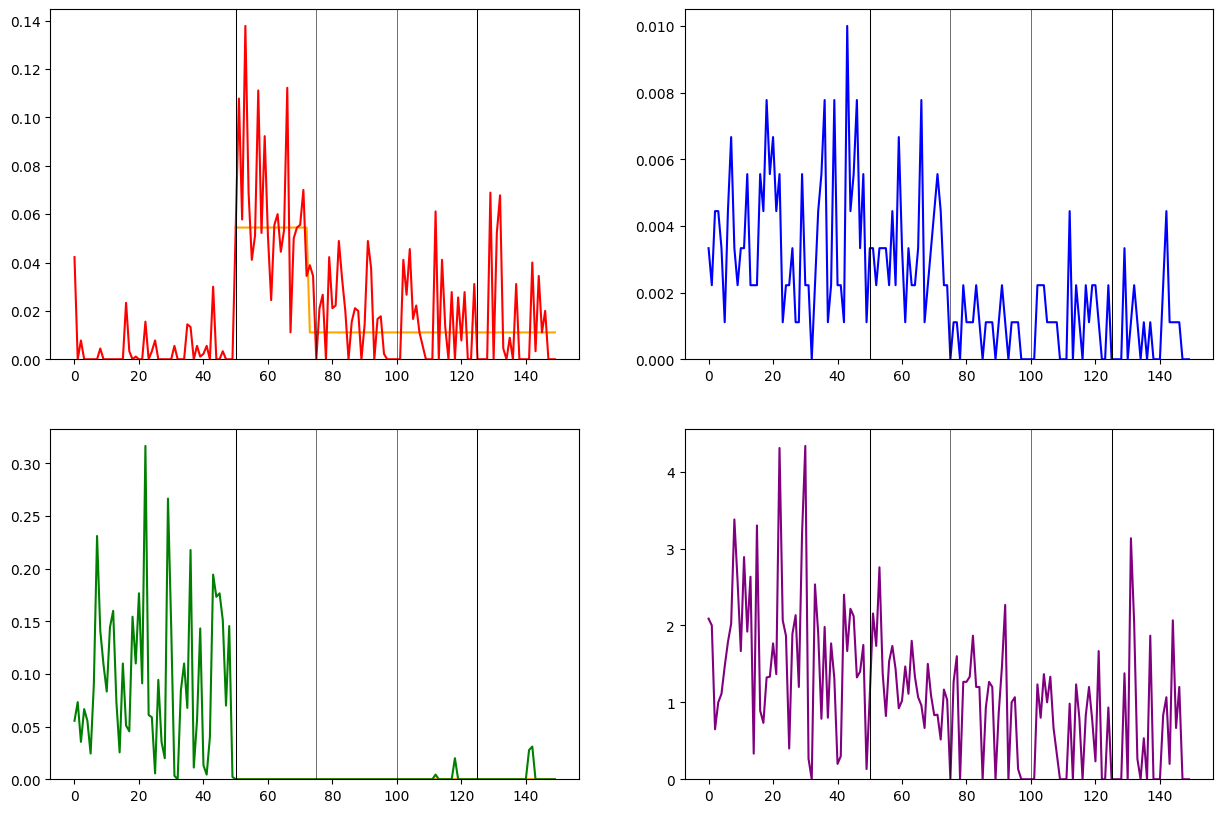

Animal 02
e:26.3 f:0.016 g:82.0 h:0.037
e:50.0 f:-0.000 g:78.9 h:0.032


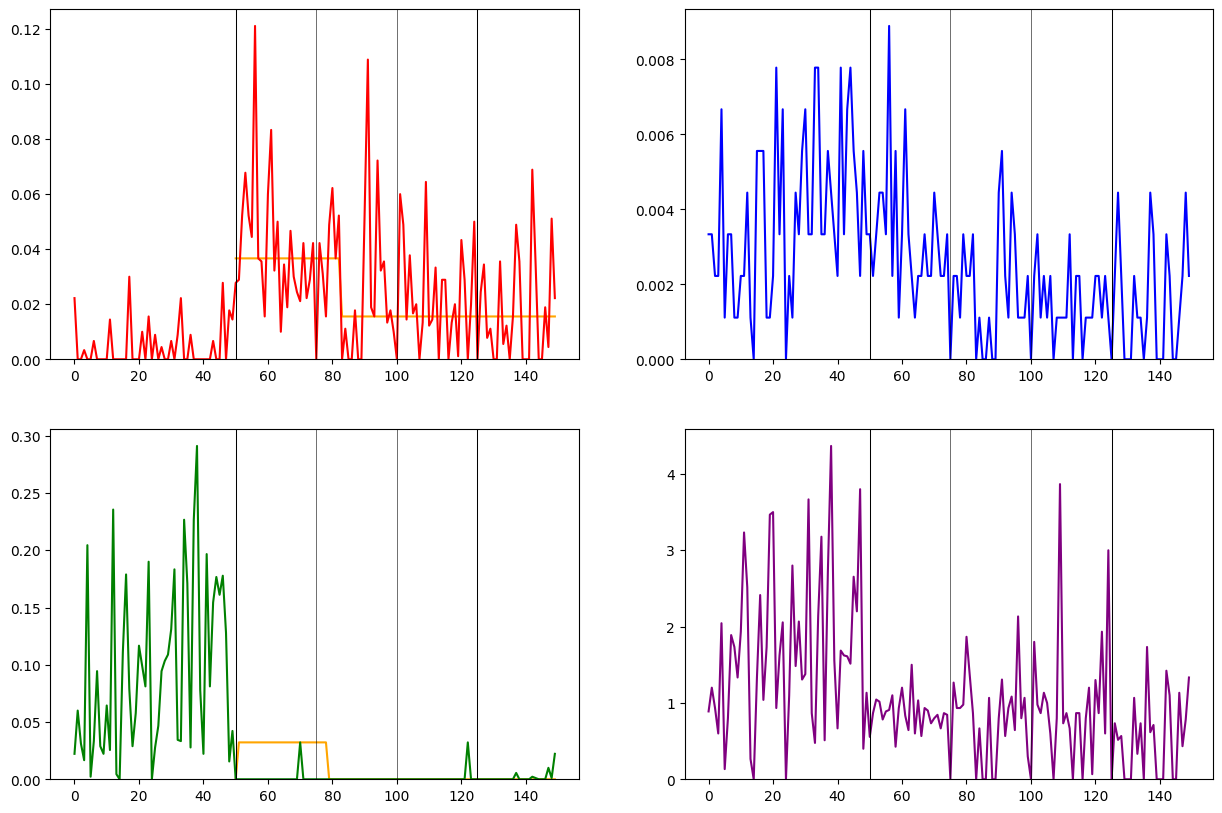

Animal 10
e:41.1 f:0.016 g:67.1 h:0.061
e:94.7 f:-0.000 g:87.3 h:0.026


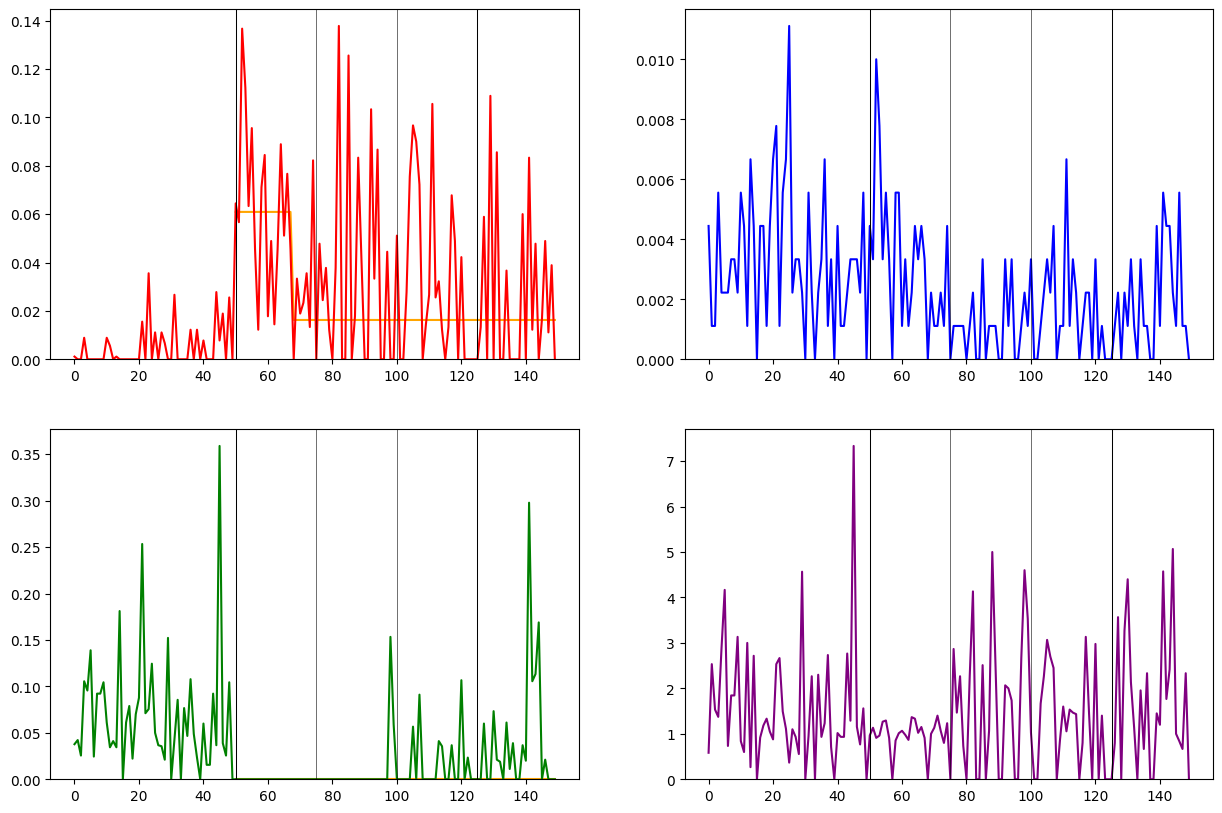

Animal 11
e:45.7 f:0.002 g:73.1 h:0.065
e:35.5 f:0.020 g:94.1 h:-0.000


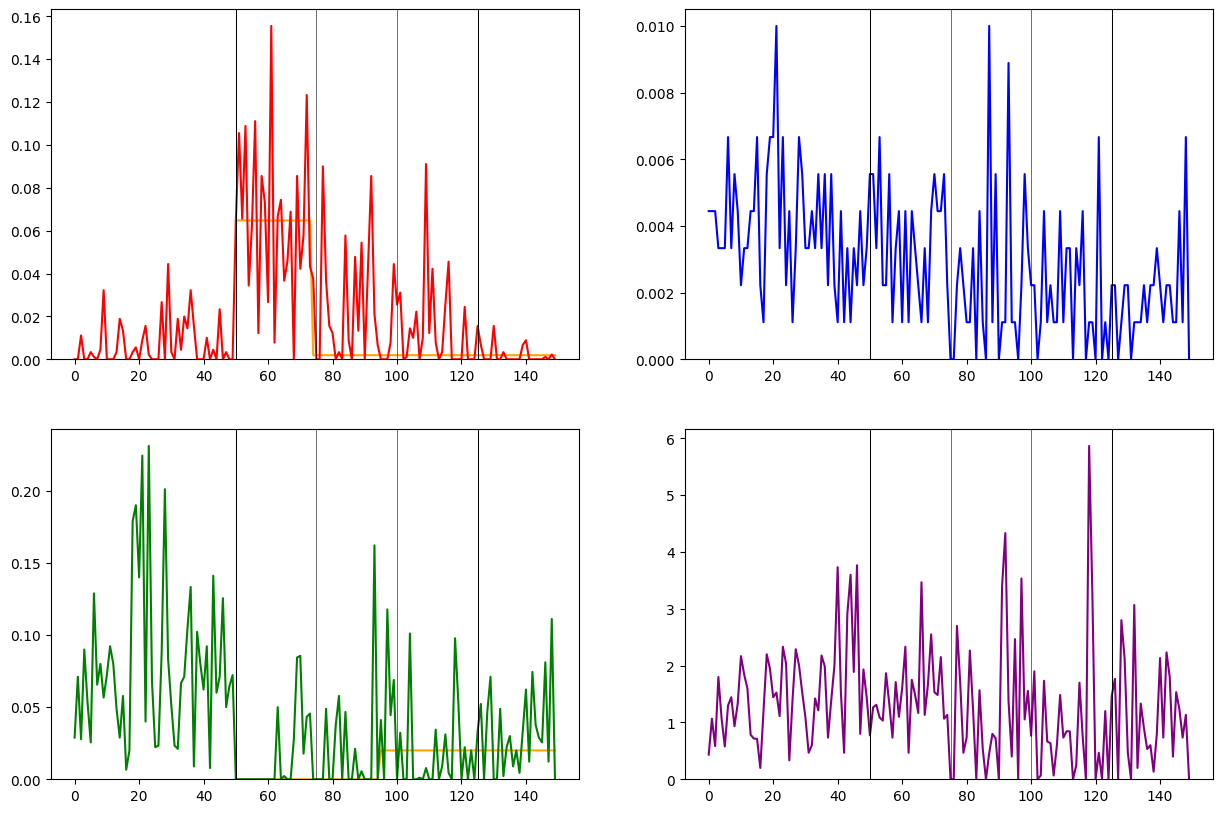

Animal 16
e:43.2 f:0.005 g:55.5 h:0.109
e:54.6 f:0.007 g:72.8 h:0.105


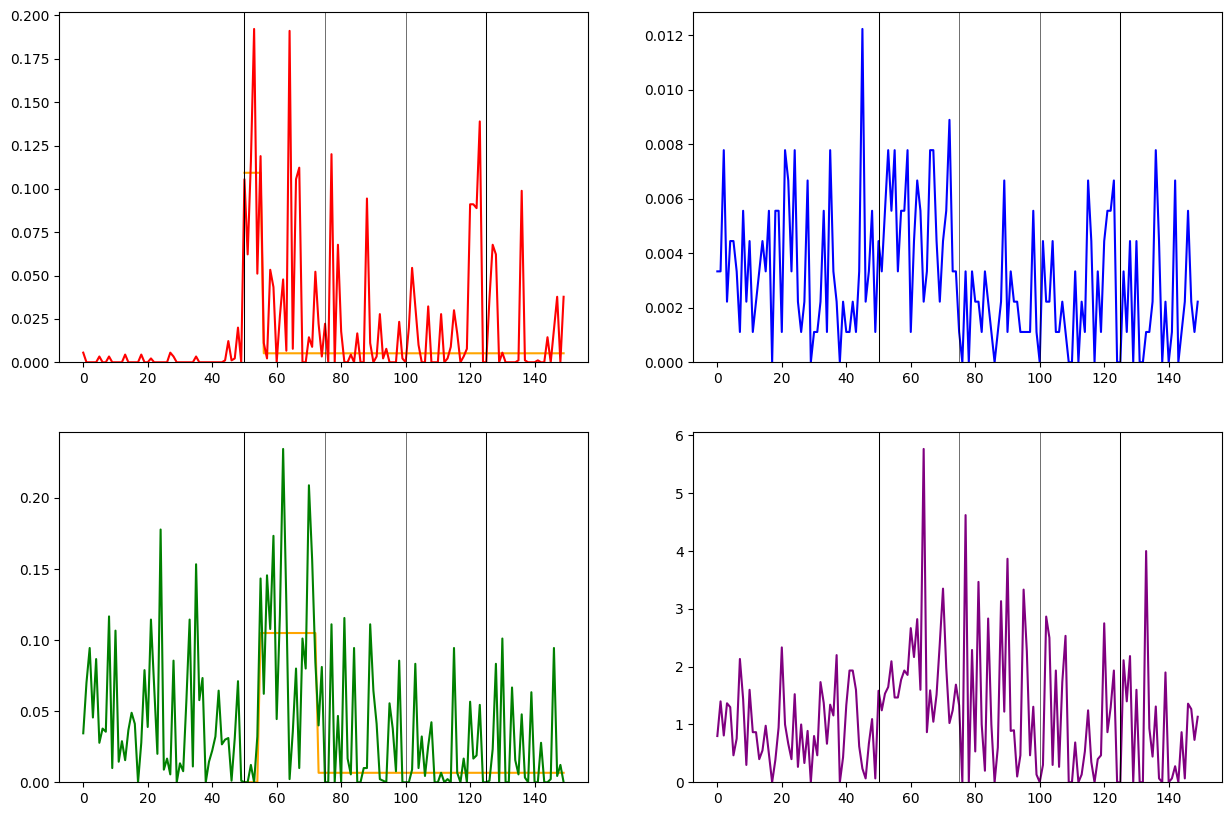

Animal 06
e:48.5 f:0.019 g:75.6 h:0.060
e:57.4 f:0.015 g:85.1 h:0.012


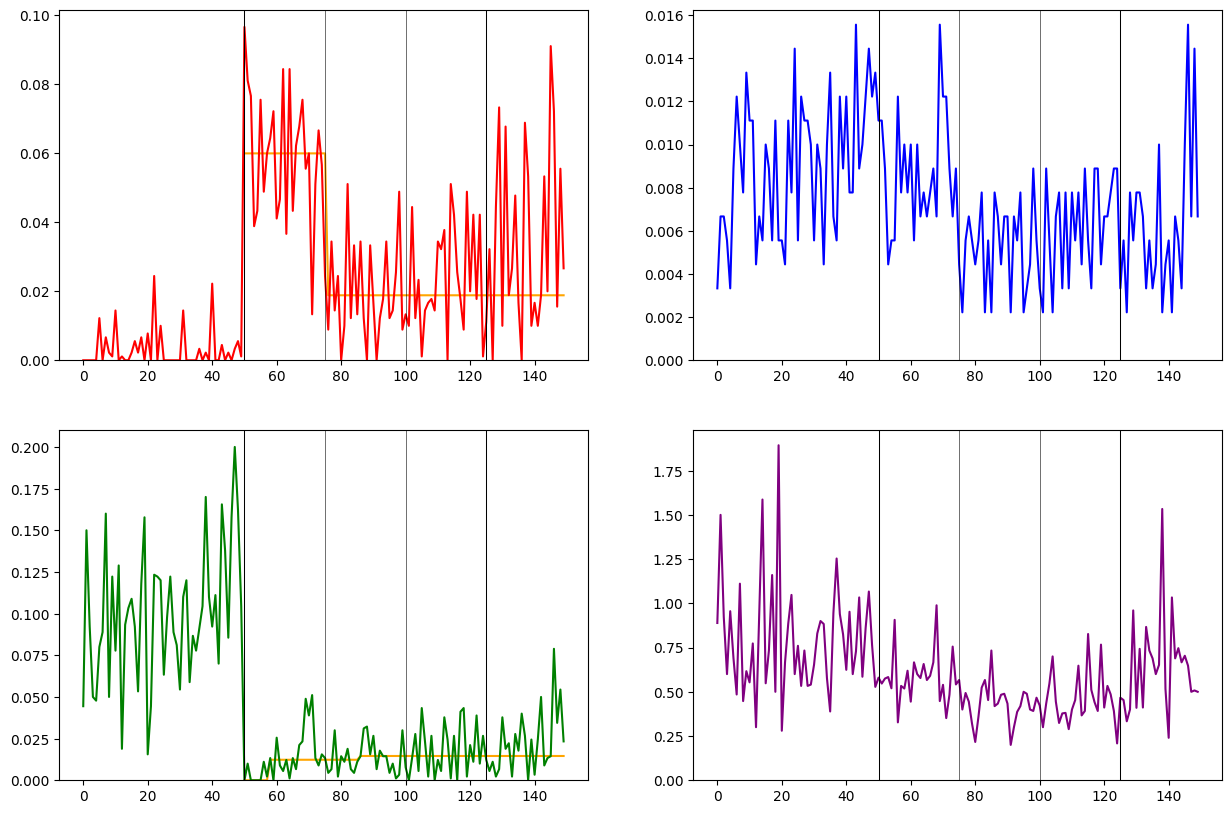

Animal 19
e:38.3 f:0.006 g:69.8 h:0.078
e:83.6 f:0.012 g:91.6 h:0.132


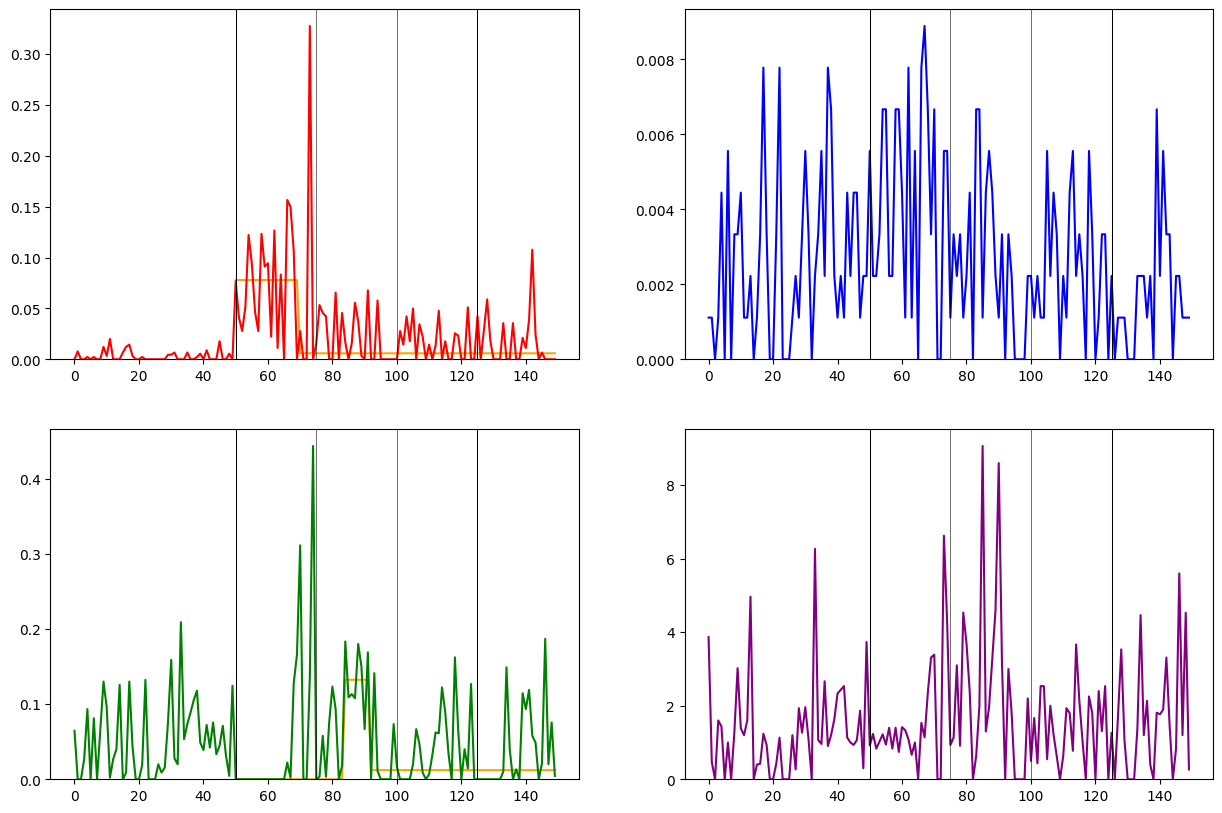

Animal 15
e:51.7 f:0.038 g:73.9 h:0.103
e:83.7 f:0.007 g:97.3 h:0.016


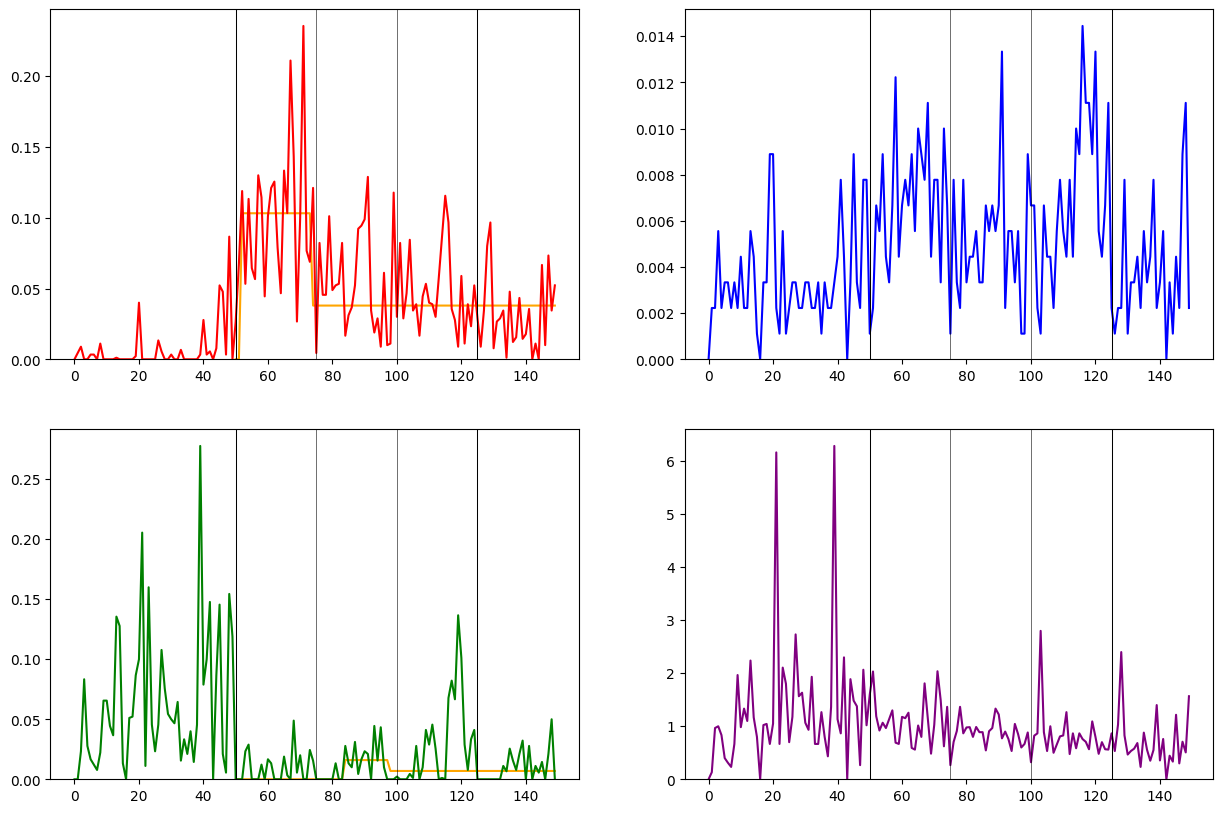

Animal 22
e:23.6 f:-0.000 g:61.8 h:0.132
e:55.3 f:0.036 g:73.4 h:0.101


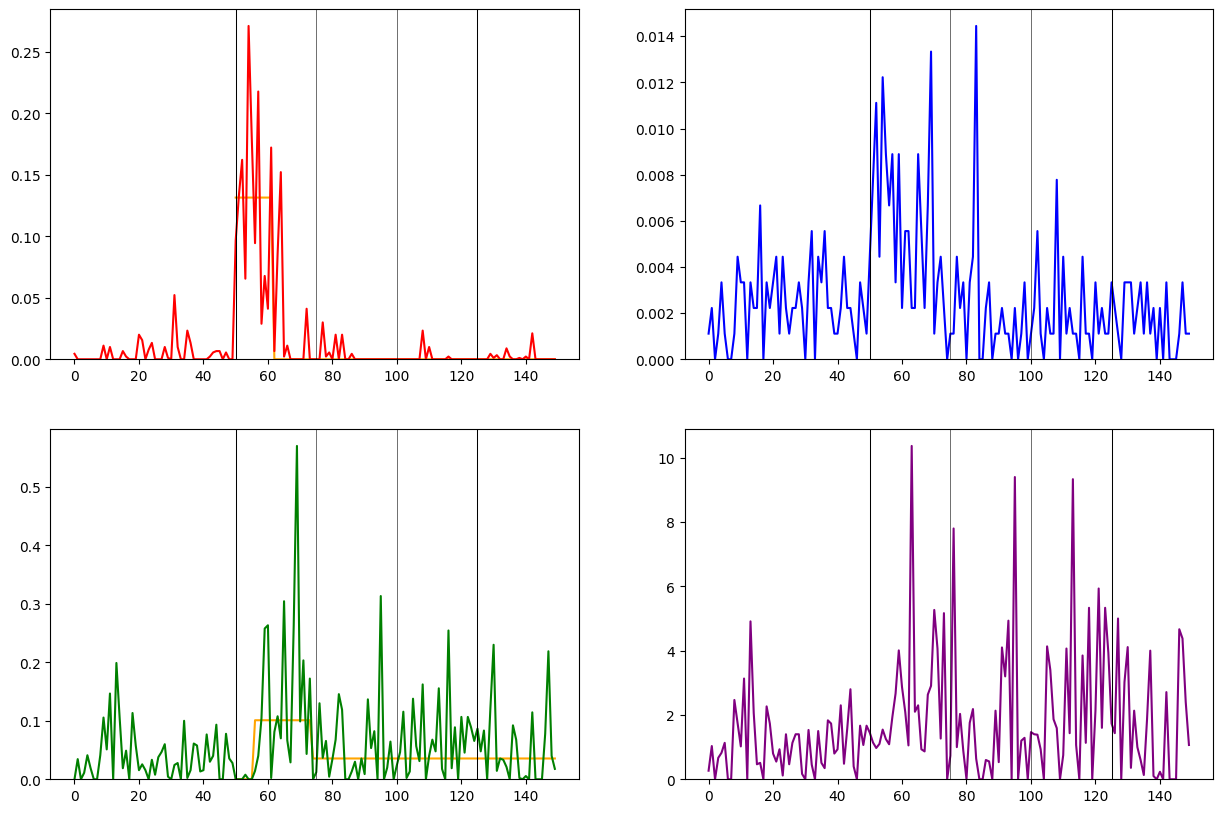

Animal 23
e:34.6 f:0.006 g:59.4 h:0.071
e:55.8 f:0.023 g:89.7 h:0.096


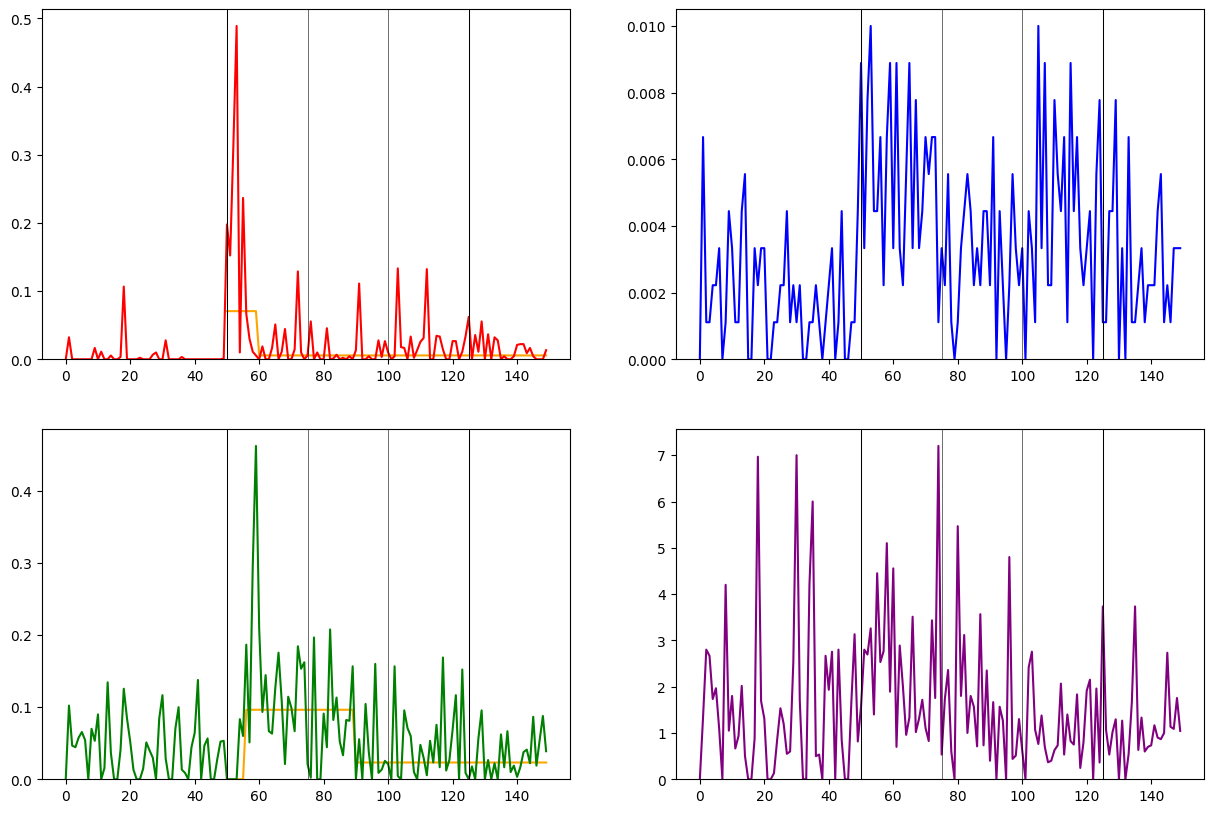

Animal 03
e:46.9 f:0.006 g:91.0 h:0.011
e:55.0 f:0.021 g:94.1 h:0.065


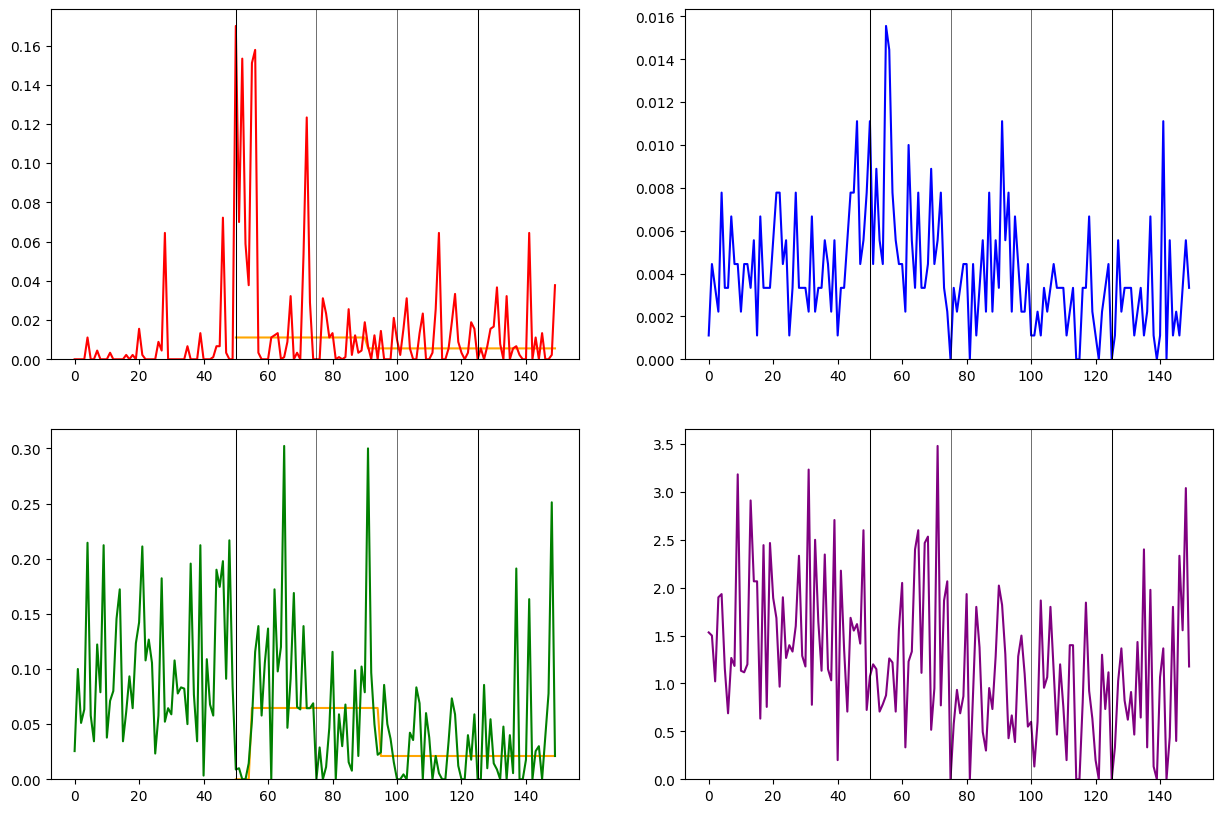

Animal 24
e:44.9 f:0.005 g:73.7 h:0.124
e:52.3 f:0.030 g:100.6 h:-0.000


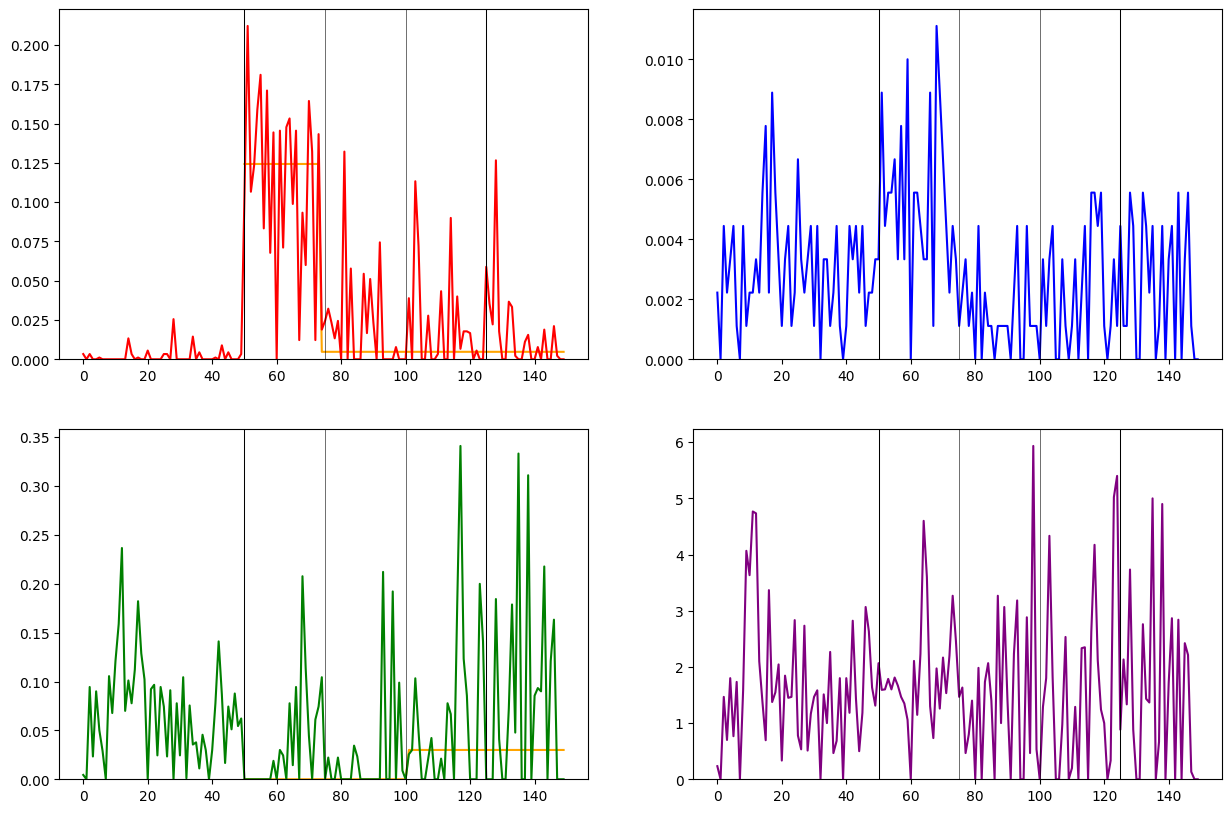

Animal 17
e:45.2 f:0.014 g:79.4 h:0.054
e:26.8 f:0.100 g:92.8 h:-0.000


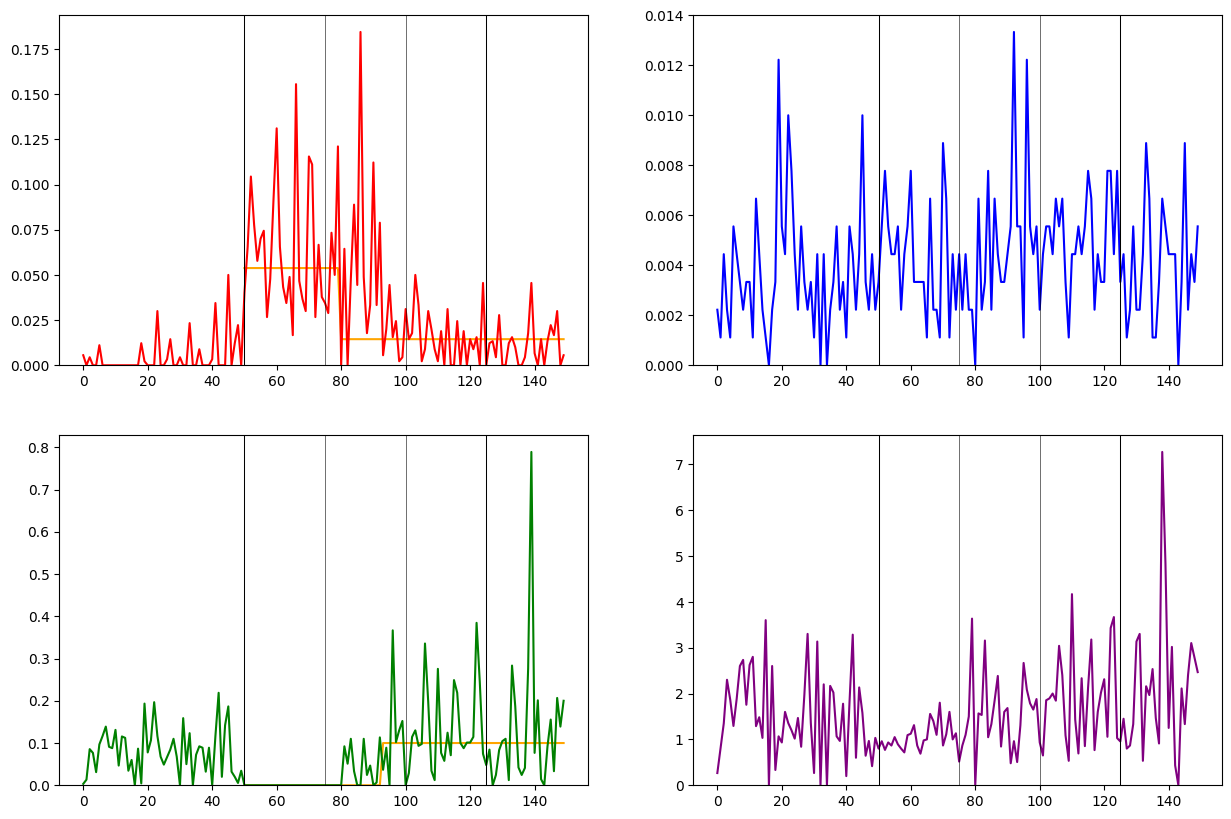

Animal 20
e:47.0 f:0.001 g:77.2 h:0.023
e:51.8 f:0.093 g:65.5 h:0.180


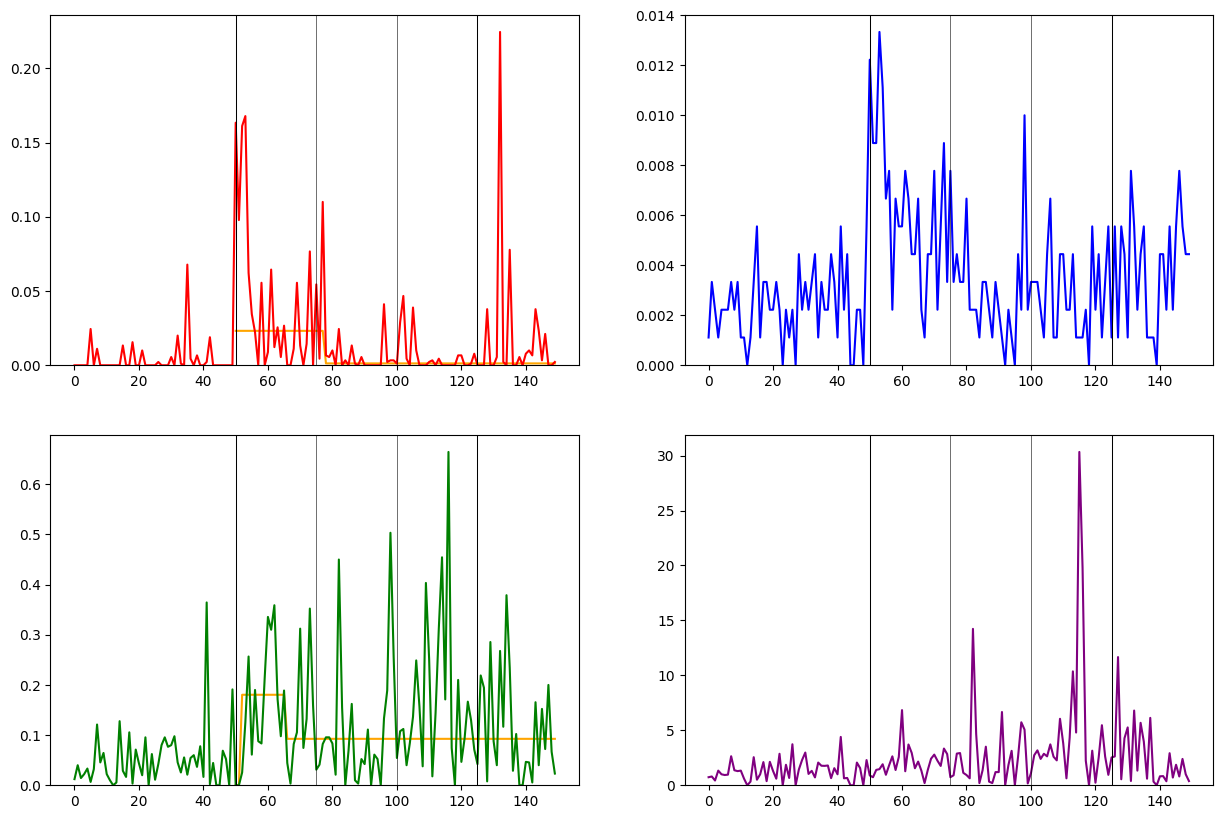

Animal 01
e:46.0 f:0.014 g:67.4 h:0.062
e:65.4 f:0.137 g:85.8 h:0.101


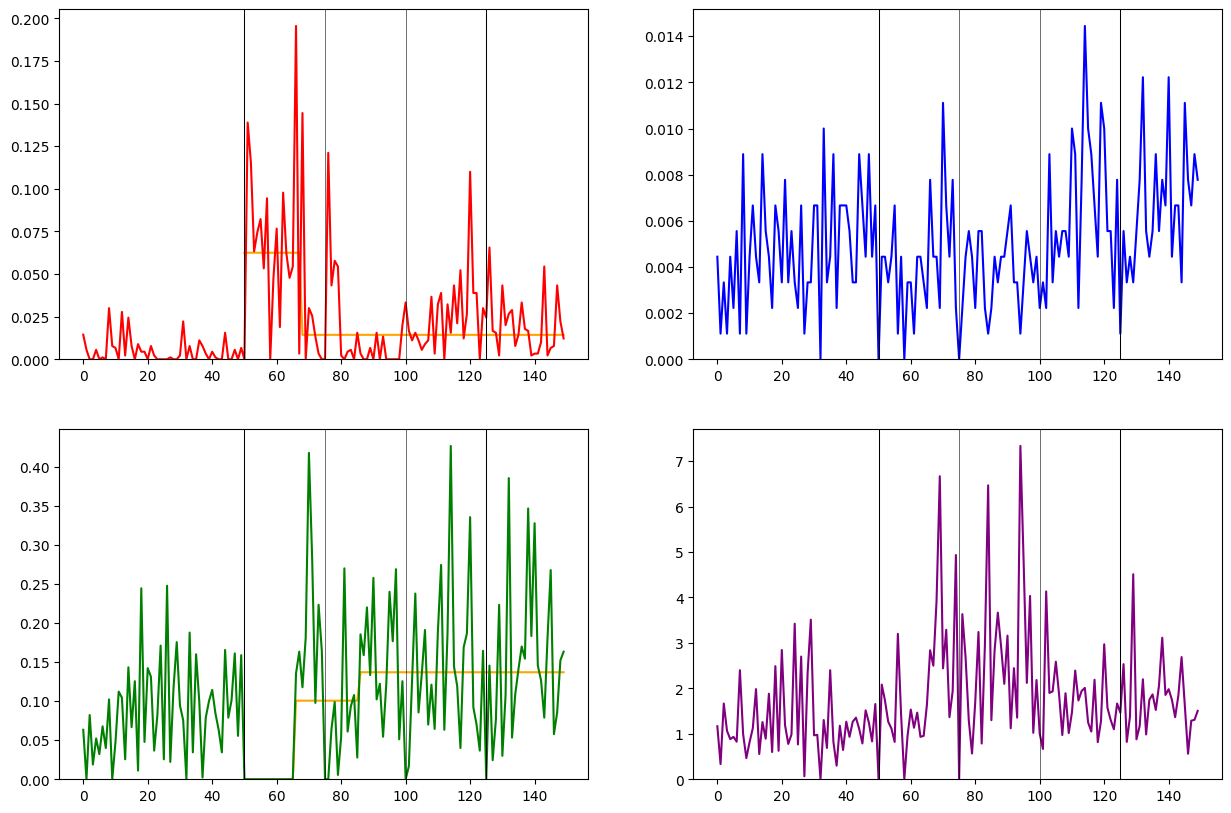

Animal 12
e:46.1 f:0.001 g:77.5 h:0.008
e:51.2 f:0.105 g:73.4 h:0.302


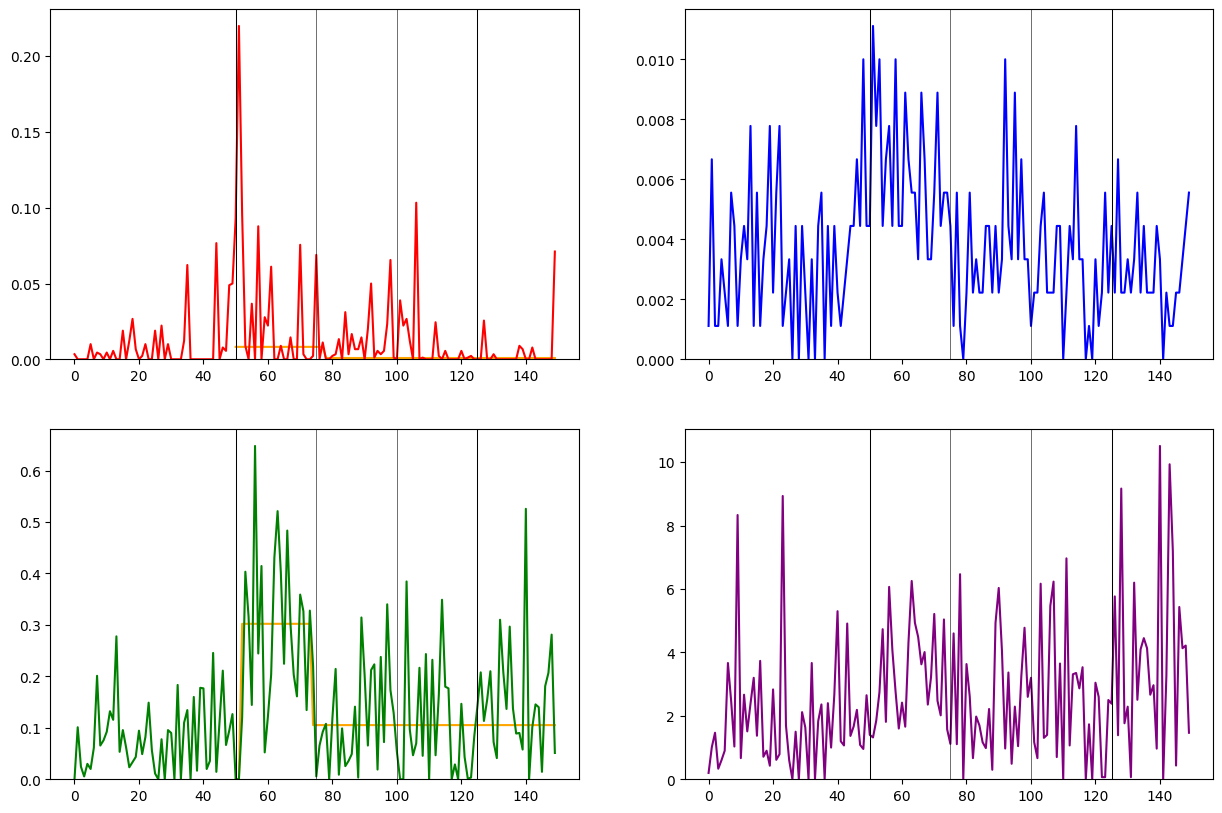

Animal 05
e:39.1 f:0.004 g:83.7 h:0.012
e:62.7 f:0.122 g:73.8 h:0.367


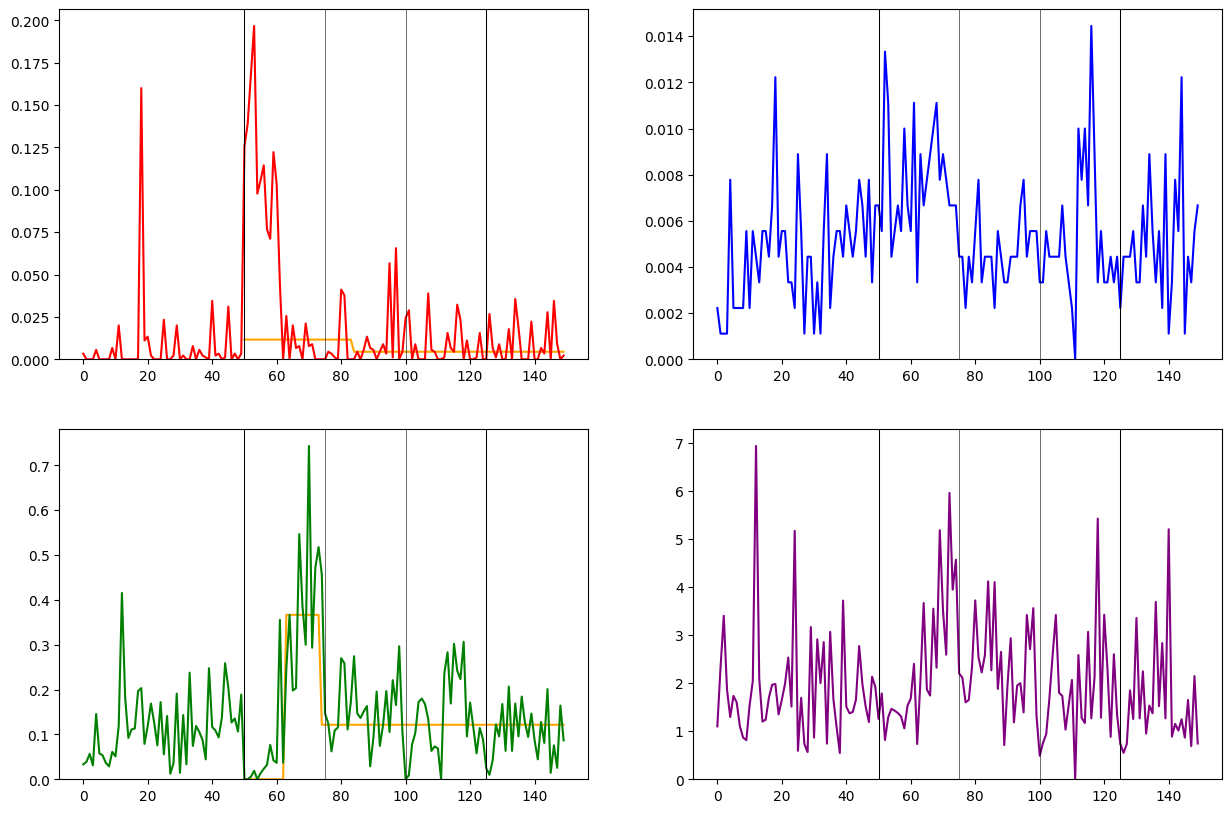

Animal 07
e:35.8 f:0.011 g:66.0 h:0.077
e:49.0 f:0.140 g:80.5 h:-0.000


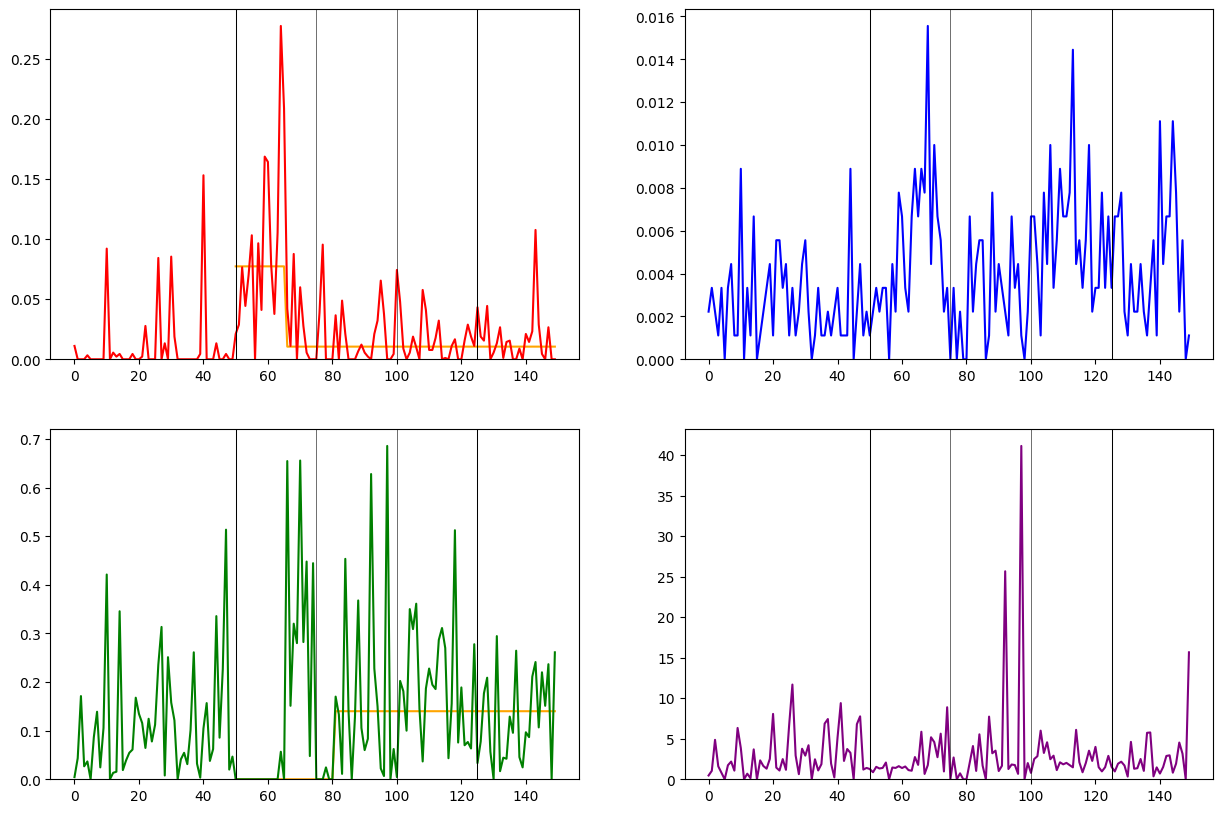

Animal 00
e:50.6 f:0.004 g:66.9 h:0.111
e:63.2 f:0.139 g:97.4 h:0.217


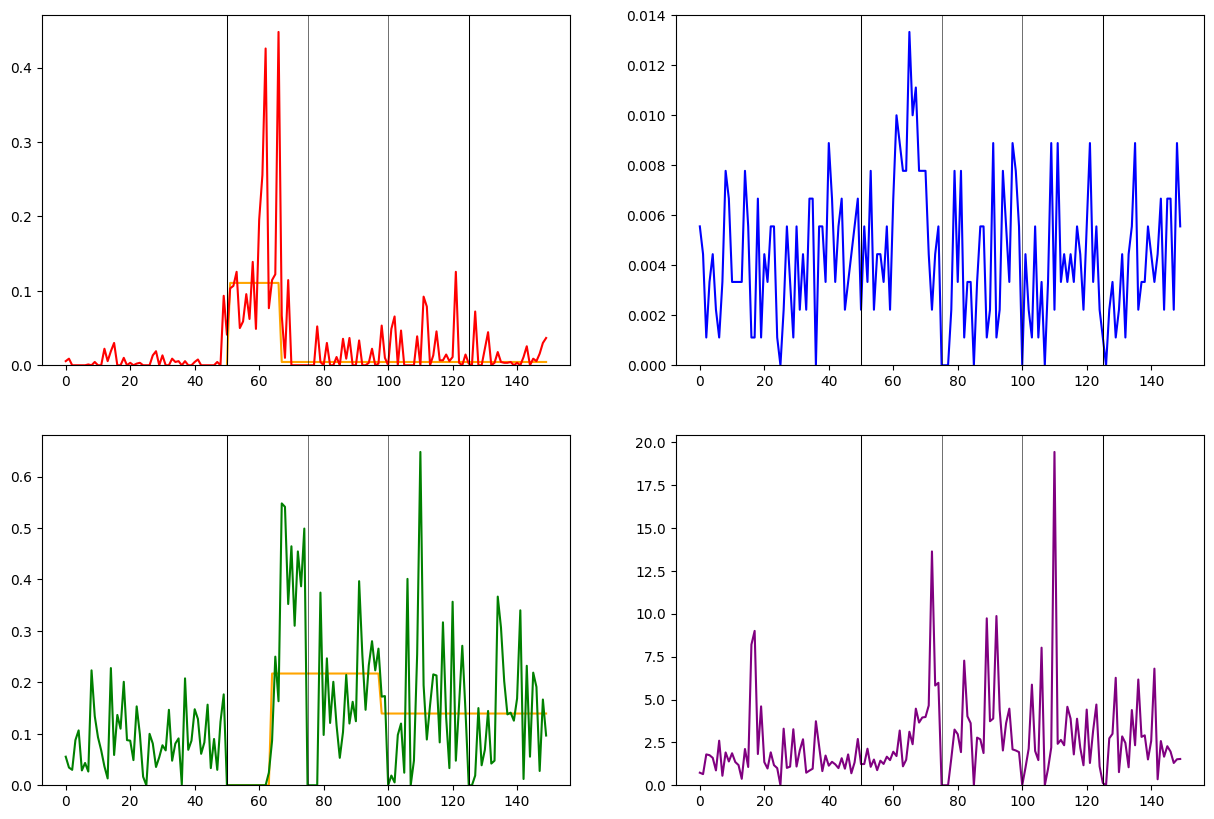

Animal 14
e:47.1 f:-0.000 g:64.4 h:0.010
e:51.1 f:0.102 g:75.8 h:0.380


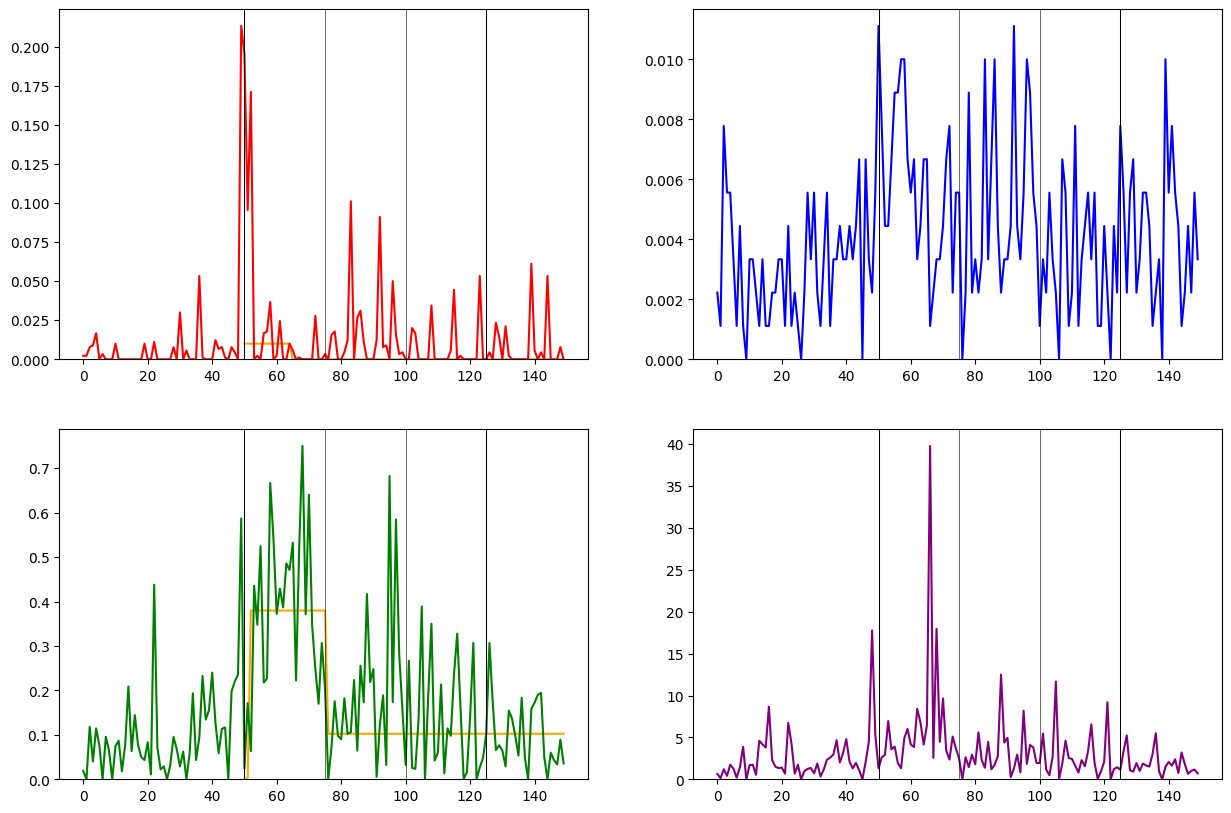

In [9]:
net_params, behind_params, front_params = plot_all([near, near_front, near_behind], partial(fit_offsetbox_model_normalized, 150))

In [10]:
gt_data = {
        "front_params": {str(k): v for k, v in front_params.items()},
        "behind_params": {str(k): v for k, v in behind_params.items()}
    }

In [11]:
timid_animals = set([18, 13, 8, 25, 21, 9, 4, 2, 15])
intermediate_animals = set([10, 11, 24, 17, 1, 6])
brave_animals = set([5, 16, 20, 12, 19, 0, 22, 23, 14, 3, 7])

In [ ]:
for i in timid_animals:
    e, f, g, h = gt_data["behind_params"][str(i)]
    print("Animal: {} Start:{:.0f} Peak: {:.3f} End: {:.0f} Steady-State: {:.3f} Ratio: {:.2f}".format(i, e, h, g, f, f/h))

In [ ]:
for i in brave_animals:
    _, _, b, _ = gt_data["behind_params"][str(i)]
    e, f, g, h = gt_data["front_params"][str(i)]
    print("Animal: {} Timid-end: {:.0f} Start:{:.0f} Peak: {:.3f} End: {:.0f} Steady-State: {:.3f} Ratio: {:.2f}".format(i, b, e, h, g, f, f/h))

In [20]:
# set c2c and p2s times to be the same for intermediate animals
for i in intermediate_animals:
    gt_data["front_params"][str(i)][2] = gt_data["front_params"][str(i)][0]

In [22]:
with open('../processed_mice_data/phase_params_test.json', 'w') as f:
    json.dump(gt_data, f)